In [1]:
from src import *
from copy import deepcopy

## Description

Computing metrics specific to one gradient or dynamic gradients.

GOAL: Compute metrics and have a snippet look at their evolution.

## Table of Contents
- [Gradient Metrics](#metrics)
    - Distance between networks of gradients
    - Brainmap of voxel motions
    - Volume Spanned by regions
    - Explained variance timeseries

<a class="anchor" id="metrics"></a>
### Gradient Metrics
Extract metrics useful to correlate with emotions timeseries  from dynamic gradients per person

Movie name used for gradient: `'TC_400_sub-S09_ses-4_Sintel.csv'`

In [4]:
# Loading Gradient Example
weight_path = "./resources/dynamic_grad/gradient_movie_ws140.npy"
G_movie  = np.load(weight_path)
G_rest   = np.load('./resources/dynamic_grad/gradient_rest_ws140.npy')

In [5]:
index2region = load('./resources/yeo7region400.pkl')
regions      = list(index2region.keys())
nbr          = len(regions)

#### Distance between networks on gradients

0.32886136379486963
11.147343251319477


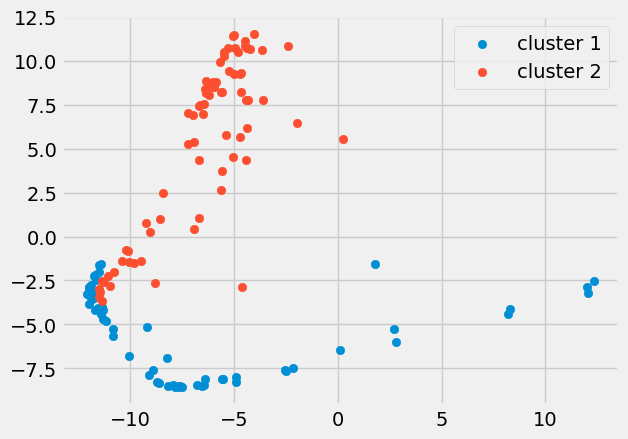

In [6]:
# e.g of distance between clusters
c1 = G_movie[0,index2region[regions[0]]]
c2 = G_movie[0,index2region[regions[1]]]

plt.scatter(c1[:,0], c1[:,1], label='cluster 1')
plt.scatter(c2[:,0], c2[:,1], label='cluster 2')
plt.legend()
print(cluster_distance(c1,c2))
print(cluster_distance(c1,c2, method="centroid"))

In [14]:
T = G_movie.shape[0]
C = np.zeros((T, nbr, nbr))
for t in tqdm(range(T)):
    for i, r1 in enumerate(regions):
        for j, r2 in enumerate(regions):
            c1 = G_movie[t, index2region[r1]]
            c2 = G_movie[t, index2region[r2]]
            C[t,i,j] = cluster_distance(c1,c2)

100%|██████████| 435/435 [03:21<00:00,  2.16it/s]


In [15]:
T = G_movie.shape[0]
C2 = np.zeros((T, nbr, nbr))
for t in tqdm(range(T)):
    for i, r1 in enumerate(regions):
        for j, r2 in enumerate(regions):
            c1 = G_movie[t, index2region[r1]]
            c2 = G_movie[t, index2region[r2]]
            C2[t,i,j] = cluster_distance(c1,c2, method="centroid")

100%|██████████| 435/435 [00:00<00:00, 988.85it/s] 


In [21]:
regions

['Vis', 'SomMot', 'DorsAttn', 'SalVentAttn', 'Limbic', 'Cont', 'Default']

Text(0.5, 0.98, 'Distance between region clusters')

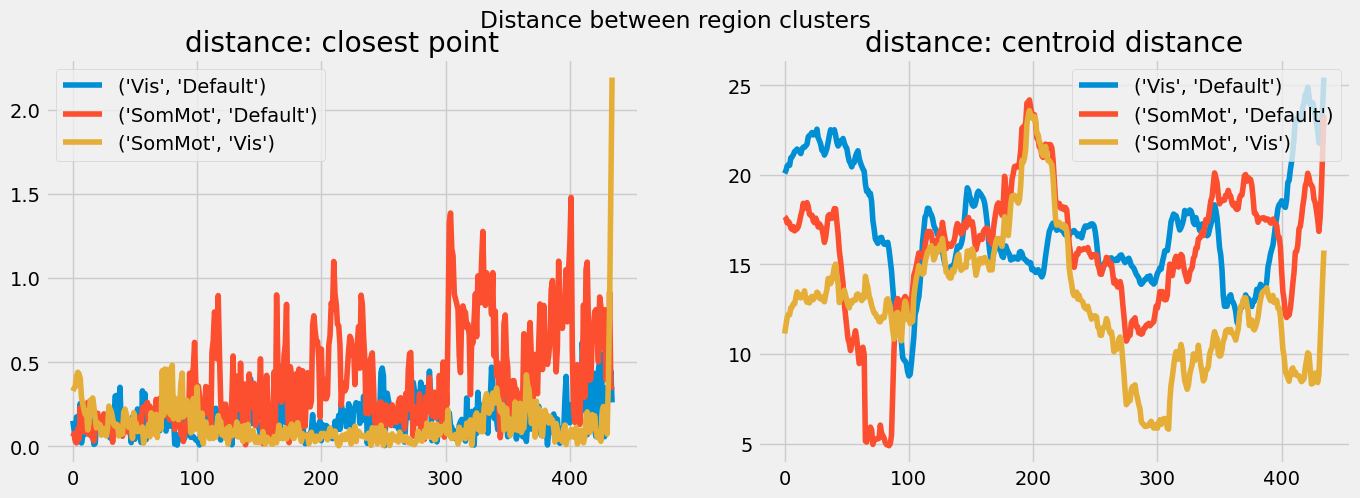

In [37]:
# select two regions and see how their cluster distance evolve
pair1 = ("Vis", "Default")
pair2 = ("SomMot", "Default")
pair3 = ("SomMot", "Vis")

fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot(C[:, regions.index(pair1[0]), regions.index(pair1[1])], label=pair1)
ax[0].plot(C[:,regions.index(pair2[0]), regions.index(pair2[1])], label=pair2)
ax[0].plot(C[:,regions.index(pair3[0]), regions.index(pair3[1])], label=pair3)
ax[1].plot(C2[:, regions.index(pair1[0]), regions.index(pair1[1])], label=pair1)
ax[1].plot(C2[:,regions.index(pair2[0]), regions.index(pair2[1])], label=pair2)
ax[1].plot(C2[:,regions.index(pair3[0]), regions.index(pair3[1])], label=pair3)
ax[0].legend()
ax[0].set_title("distance: closest point")
ax[1].legend()
ax[1].set_title("distance: centroid distance")
plt.suptitle('Distance between region clusters')

#### Heat map of motion of regions

In [74]:
d_movie = []
d_rest  = []

# For each point we look at its movement over time and compute its mean 
# the mean acts as a way of knowing how much in average that point moves
for r in range(G_movie.shape[1]):
    tmpA = G_movie[:, r][:-1]
    tmpB = G_movie[:, r][1:]

    Dm = np.asarray([ points_distance(tmpA[pidx], tmpB[pidx], pmethod="L2") 
                    for pidx in range(len(tmpA))])
    d_movie.append(Dm.mean())

for r in range(G_rest.shape[1]):
    tmpA = G_rest[:, r][:-1]
    tmpB = G_rest[:, r][1:]

    Dr = np.asarray([ points_distance(tmpA[pidx], tmpB[pidx], pmethod="L2") 
                    for pidx in range(len(tmpA))])
    d_rest.append(Dr.mean())

d_movie = np.asarray(d_movie)
d_rest  = np.asarray(d_rest)

Text(0.5, 1.0, "voxel's gradient motion distribution")

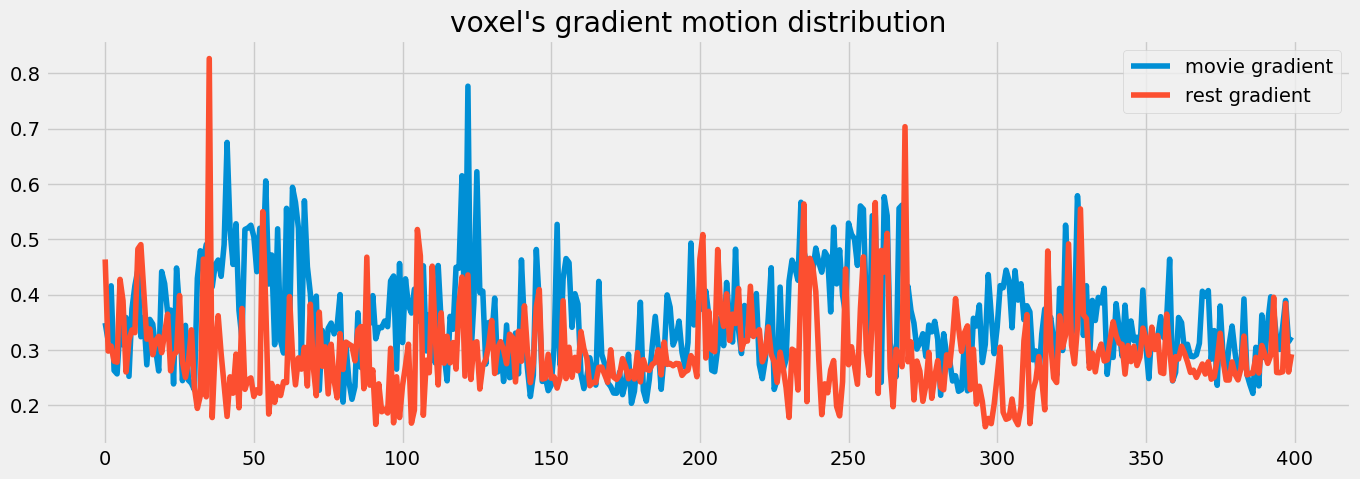

In [77]:
plt.figure(figsize=(15,5))
plt.plot(d_movie, label='movie gradient')
plt.plot(d_rest, label='rest gradient')
plt.legend()
plt.title("voxel's gradient motion distribution")


/Users/michaelc.c.h/opt/miniconda3/envs/brain/lib/python3.8/site-packages/brainspace/plotting/surface_plotting.py:437: RuntimeWarning: Running plot_hemispheres without a display may result in a crash. For a workaround please consult https://github.com/MICA-MNI/BrainSpace/issues/66. To suppress this warning set suppress_warnings=True.
  warnings.warn(


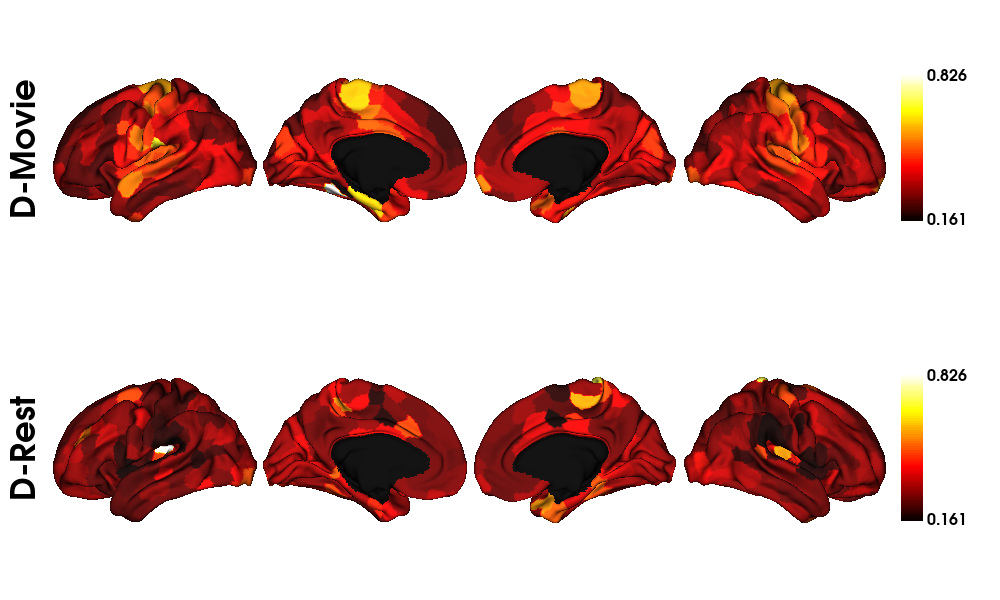

In [87]:
labeling         = load_parcellation('schaefer', scale=400, join=True)
surf_lh, surf_rh = load_conte69()


mask = labeling != 0
gs   = deepcopy([d_movie, d_rest])

# TODO: to fix, we are currently artificially fixing the value bar
gs[0][0] = gs[1].max()
gs[0][1] = gs[1].min()
grad = [None] * 2
for k in range(2):
    # map the gradient to the parcels
    grad[k] = map_to_labels(gs[k], labeling, mask=mask, fill=np.nan)



plot_hemispheres(surf_lh, surf_rh, array_name=grad, size=(1000, 600), cmap='hot',
                 color_bar=True, label_text=['D-Movie', 'D-Rest'], zoom=1.25, embed_nb=True, interactive=False,
                 transparent_bg=False)


#### Compute volume spanned by a region on multiple gradients shape
For instance we have a 3d cloud of points and we can then compute a proxy of the volume of the convex hull spanned by the cloud of points.

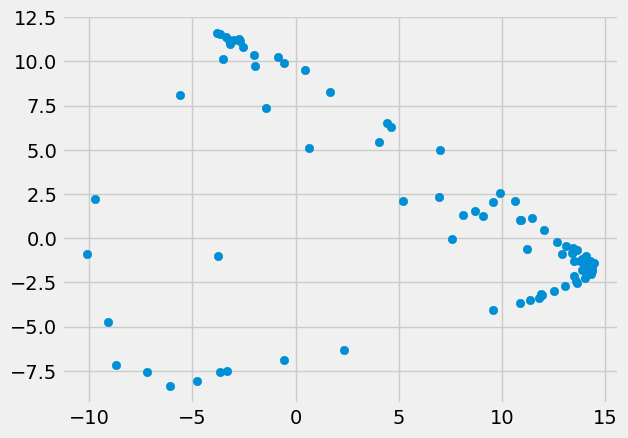

In [14]:
iidx = index2region['Default']
plt.scatter(G_movie[0,iidx,0], G_movie[0,iidx,1])

In [30]:
%timeit network_volume(G_movie[0],iidx)

1.28 ms ± 17.4 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [31]:
%timeit network_volume(G_movie[0],iidx,method='hull')

208 µs ± 9.52 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


#### Explained variance timeseries

In [3]:
LM = np.load('./resources/lambdas_movie_ws200_Sintel.npy')
LR = np.load('./resources/lambdas_rest_ws200_Sintel.npy')

Text(0.5, 1.0, 'Explained variance over time for REST ws=200')

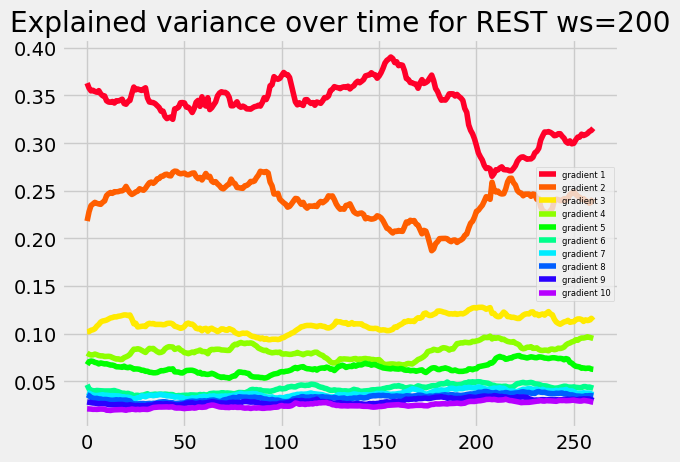

In [14]:
NUM_COLORS = LM.shape[1]
cm = plt.get_cmap('gist_rainbow')
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

for i in range(NUM_COLORS):
    ax.plot(LR[:,i]/LR.sum(axis=1), label='gradient {}'.format(i+1))
ax.legend(loc=5, prop={'size':6})
ax.set_title("Explained variance over time for REST ws=200")

Text(0.5, 1.0, 'Explained variance over time for MOVIE ws=200')

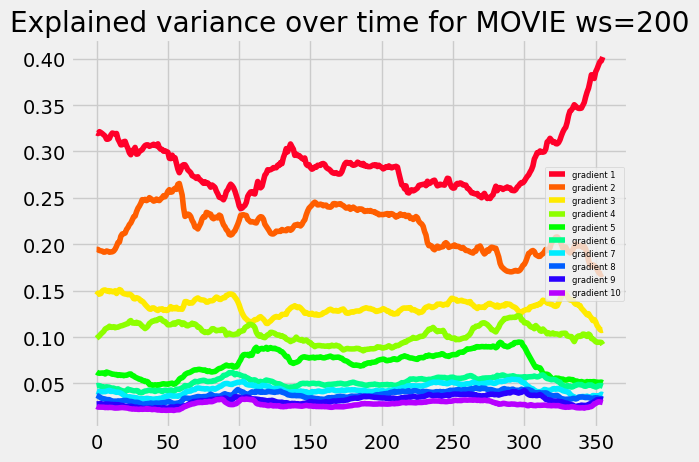

In [15]:
NUM_COLORS = LM.shape[1]
cm = plt.get_cmap('gist_rainbow')
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

for i in range(NUM_COLORS):
    ax.plot(LM[:,i]/LM.sum(axis=1), label='gradient {}'.format(i+1))
ax.legend(loc=5, prop={'size':6})
ax.set_title("Explained variance over time for MOVIE ws=200")